In [120]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from scipy.signal import periodogram
from statsmodels.tsa.deterministic import DeterministicProcess
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.linear_model import LinearRegression

### Retrieve dataset

In [95]:
df = pd.read_csv('../input/spy.csv')

# Verify if no nan or inf values
print(df.isna().sum())
print(np.isinf(df[['Close', 'Volume', 'Weekday']]).sum())

df

Date       0
Open       0
High       0
Low        0
Close      0
Volume     0
Day        0
Weekday    0
Week       0
Month      0
Year       0
dtype: int64
Close      0
Volume     0
Weekday    0
dtype: int64


,Date,Open,High,Low,Close,Volume,Day,Weekday,Week,Month,Year
0,1993-01-29,24.543517,24.543517,24.421410,24.526073,1003200,29,4,4,1,1993
1,1993-02-01,24.543515,24.700510,24.543515,24.700510,480500,1,0,5,2,1993
2,1993-02-02,24.683072,24.770292,24.630741,24.752848,201300,2,1,5,2,1993
3,1993-02-03,24.787724,25.031938,24.770280,25.014494,529400,3,2,5,2,1993
4,1993-02-04,25.101718,25.171493,24.822616,25.119162,531500,4,3,5,2,1993
...,...,...,...,...,...,...,...,...,...,...,...
8072,2025-02-24,602.020020,603.030029,596.489990,597.210022,50737200,24,0,9,2,2025
8073,2025-02-25,597.150024,597.890015,589.559998,594.239990,58266500,25,1,9,2,2025
8074,2025-02-26,595.929993,599.580017,591.859985,594.539978,43321600,26,2,9,2,2025
8075,2025-02-27,596.849976,598.020020,584.650024,585.049988,74196700,27,3,9,2,2025


### US stocks data time accuracy

In [96]:
stock_dates = pd.to_datetime(df['Date']) 
all_weekdays = pd.date_range(
    start=stock_dates.min(), 
    end=stock_dates.max(), 
    freq='B'   # Business days
)
missing_dates = all_weekdays.difference(stock_dates)
missing_info = pd.DataFrame({
    'missing_date': missing_dates,
    'weekday': missing_dates.weekday 
})
missing_info

print(f"We have an average of {len(missing_info) / (len(df) // (5*52))} public holidays a year so that seems fairly good")

We have an average of 9.483870967741936 public holidays a year so that seems fairly good


### Plots

In [97]:
# Convert 'Date' to datetime 
df['Date'] = pd.to_datetime(df['Date'])
# df.set_index('Date', inplace=True)

def stocks_plot(df, targets=None, split_id=None, start_date=None, end_date=None, format='%Y'):
    # Sample the data
    df_sampled = df.iloc[::10].copy()

    # Filter the DataFrame
    df_filtered = df_sampled.copy()
    if start_date:
        df_filtered = df_filtered[df_filtered['Date'] >= start_date]
    if end_date:
        df_filtered = df_filtered[df_filtered['Date'] <= end_date]

    # Handle a single target or list of targets
    if isinstance(targets, str):
        targets = [targets]  # make it a list so we can loop

    plt.figure(figsize=(8, 4))

    # Plot each target column
    for target in targets:
        plt.plot(df_filtered['Date'], df_filtered[target], label=target)

    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.title('Stocks Over Time')

    # Format x-axis
    plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter(format))
    plt.xticks(rotation=45)

    # X-axis limits
    plt.xlim(start_date, end_date)

    # Y-axis range: combine all values
    y_min = df_filtered[targets].min().min() * 0.95
    y_max = df_filtered[targets].max().max() * 1.05
    plt.ylim(y_min, y_max)

    if split_id:
        plt.axvline(
        x=df['Date'].iloc[split_id],
        color='red',
        linestyle='--',
        label='Train/Test split'
    )

    plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)
    plt.legend()
    plt.tight_layout()
    plt.show()

## Statistical analysis - time and serial dependence

### Trend analysis

In [98]:
window_size = 1000
df_ma = df.copy()
df_ma['Moving Average'] = df['Close'].rolling(
    window=window_size,     
    center=True,      
    min_periods=window_size//2,  
).mean()
df_ma.head()  

,Date,Open,High,Low,Close,Volume,Day,Weekday,Week,Month,Year,Moving Average
0,1993-01-29,24.543517,24.543517,24.421410,24.526073,1003200,29,4,4,1,1993,26.194337
1,1993-02-01,24.543515,24.700510,24.543515,24.700510,480500,1,0,5,2,1993,26.196802
2,1993-02-02,24.683072,24.770292,24.630741,24.752848,201300,2,1,5,2,1993,26.199329
3,1993-02-03,24.787724,25.031938,24.770280,25.014494,529400,3,2,5,2,1993,26.201993
4,1993-02-04,25.101718,25.171493,24.822616,25.119162,531500,4,3,5,2,1993,26.204701


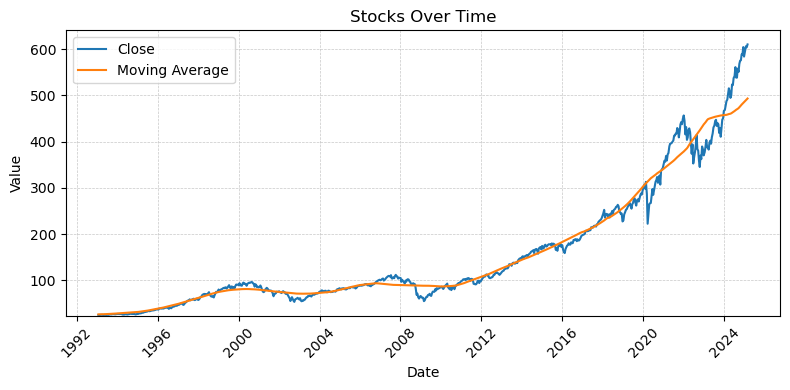

In [99]:
stocks_plot(df_ma, ['Close', 'Moving Average'])

In [100]:
dp = DeterministicProcess(
    index=df['Date'],  
    constant=True,       
    order=3,          
    drop=True,    
)

# in_sample() creates features for the dates given in the `index` argument
df_dp = dp.in_sample()
df_dp.head()

,const,trend,trend_squared,trend_cubed
Date,,,,
1993-01-29,1.0,1.0,1.0,1.0
1993-02-01,1.0,2.0,4.0,8.0
1993-02-02,1.0,3.0,9.0,27.0
1993-02-03,1.0,4.0,16.0,64.0
1993-02-04,1.0,5.0,25.0,125.0


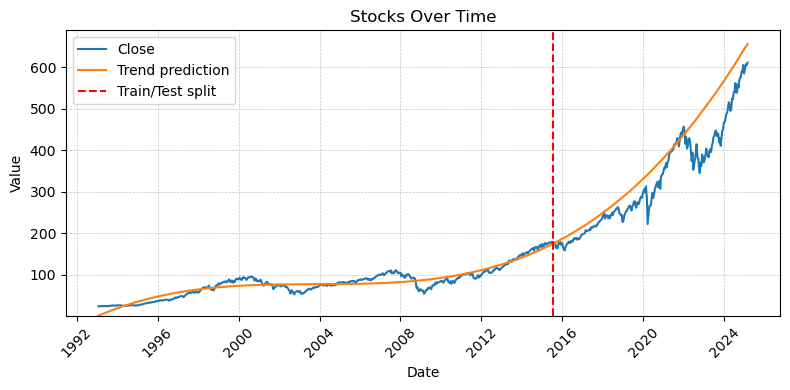

In [101]:
# Define train/test split
frac = 0.7
split_id = int(len(df) * frac)

# The intercept is the same as the const feature from DeterministicProcess
model = LinearRegression(fit_intercept=False)
model.fit(df_dp.iloc[:split_id], df["Close"].iloc[:split_id])

df_pred = df.copy()
df_pred["Trend prediction"] = model.predict(df_dp)

stocks_plot(df_pred, ['Close', 'Trend prediction'], split_id=split_id)

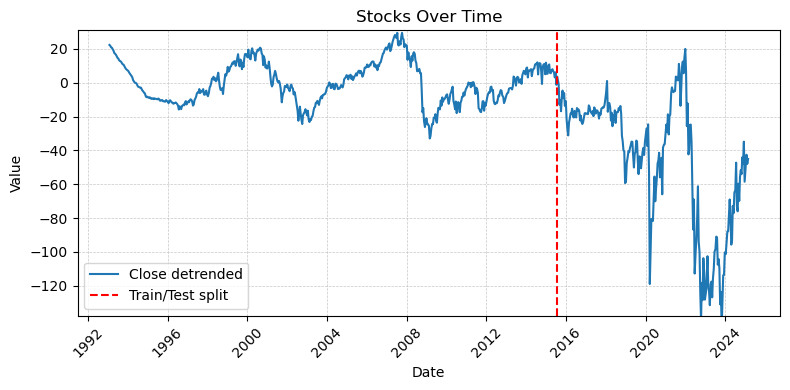

In [127]:
df_pred['Close detrended'] = df_pred['Close'] - df_pred['Trend prediction']
stocks_plot(df_pred, ['Close detrended'], split_id=split_id)

### Returns

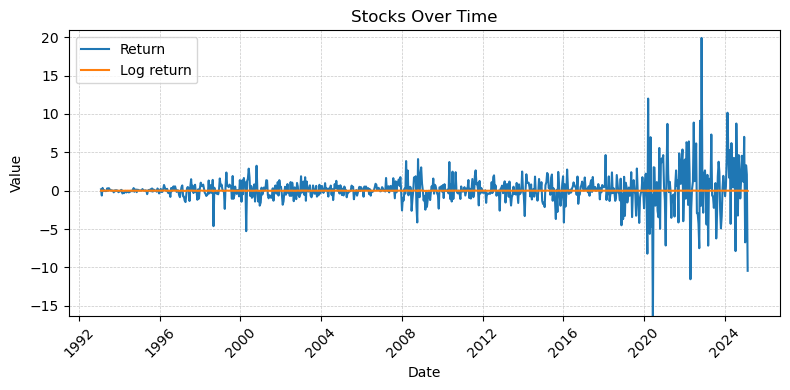

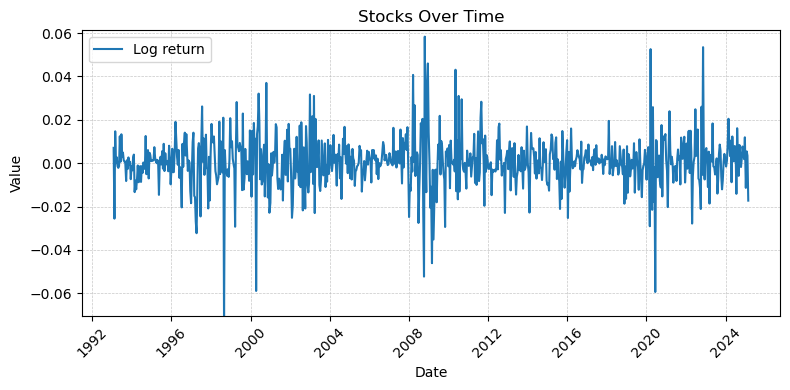

In [111]:
df_return = df.copy()
df_return["Return"] = df_return['Close'].diff()
df_return["Log return"] = np.log(df_return['Close']).diff()
df_return = df_return.dropna()

stocks_plot(df_return, ['Return', 'Log return'])
stocks_plot(df_return, ['Log return'])

### Seasonality analysis

Fourier transform assume that the underlying data is stationary, meaning its statistical properties do not change over time such as mean, variance or autocorrelation

2.018495376155961


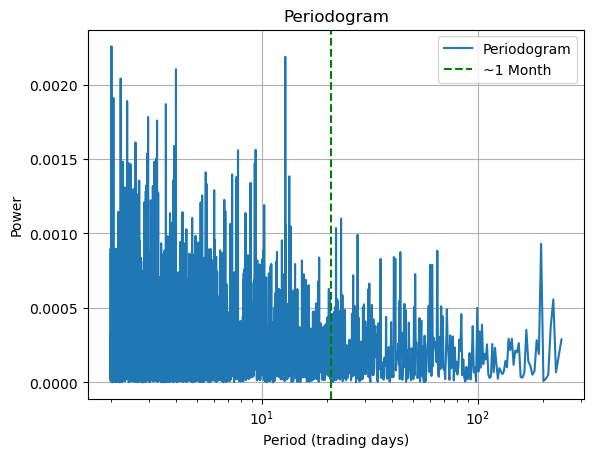

In [119]:
freqs_pgram, power_pgram = periodogram(df_return['Log return'], fs=1)  
periods_pgram = 1 / freqs_pgram[1:]  # exclude the zero frequency
power_pgram = power_pgram[1:] 

# Add limit to periods
periods_ul = 252  # ~1 year
periods_pgram = periods_pgram[periods_pgram <= periods_ul]
power_pgram = power_pgram[:len(periods_pgram)]

# Get the frequency of max power
max_idx = np.argmax(power_pgram[1:]) + 1
dominant_period = periods_pgram[max_idx]
print(dominant_period)

# Plot
# Random signal spreads energy across all frequencies (white noise)
# Small energy concentration at beginning frequencies (colored noise)
plt.plot(periods_pgram, power_pgram, label='Periodogram')
plt.xscale('log')
plt.xlabel("Period (trading days)")
plt.ylabel("Power")
plt.title("Periodogram")
plt.axvline(21, color='g', linestyle='--', label='~1 Month')
plt.grid()
plt.legend()
plt.show()

### Lag features

- Use AR (Auto Regressive), MA (Moving Average), ARMA and ARIMA (I = integration = differencing the series to make it stationary) models for predicting values
- Also assume that the underlying data is stationary 
- Use ARCH (Autoregressive Conditional Heteroskedasticity) for predicting variance that changes over time

In [116]:
def create_lags(df, target, n_lags):
    return {
            f'{target} lag {i}': df[target].shift(i)
            for i in range(1, n_lags + 1)
        }

n_lags = 5
lag_features_dict = create_lags(df_return, 'Log return', n_lags)
df_lag = df_return.assign(**lag_features_dict)
df_lag.dropna(inplace=True)
df_lag.head()

,Date,Open,High,Low,Close,Volume,Day,Weekday,Week,Month,Year,Return,Log return,Log return lag 1,Log return lag 2,Log return lag 3,Log return lag 4,Log return lag 5
6,1993-02-08,25.101723,25.188942,25.066835,25.101723,596100,8,0,6,2,1993,0.000000,0.000000,-0.000694,0.004176,0.010515,0.002117,0.007087
7,1993-02-09,25.014511,25.014511,24.874960,24.927292,122100,9,1,6,2,1993,-0.174431,-0.006973,0.000000,-0.000694,0.004176,0.010515,0.002117
8,1993-02-10,24.927288,24.979619,24.857512,24.962175,379600,10,2,6,2,1993,0.034883,0.001398,-0.006973,0.000000,-0.000694,0.004176,0.010515
9,1993-02-11,24.997057,25.188939,24.997057,25.084276,19500,11,3,6,2,1993,0.122101,0.004880,0.001398,-0.006973,0.000000,-0.000694,0.004176
10,1993-02-12,25.049396,25.049396,24.892401,24.892401,42500,12,4,6,2,1993,-0.191875,-0.007679,0.004880,0.001398,-0.006973,0.000000,-0.000694


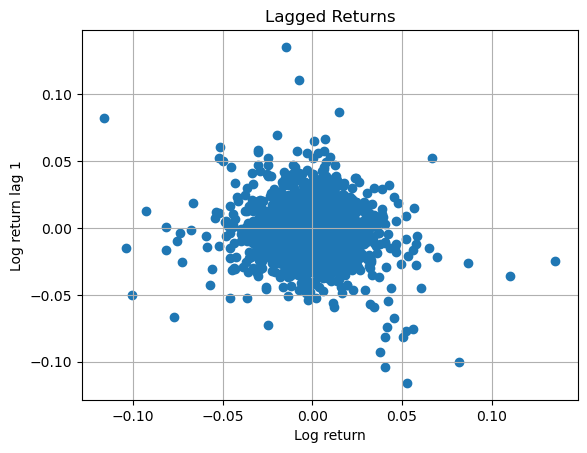

In [126]:
lag = 1
plt.scatter(df_lag['Log return'], df_lag[f'Log return lag {lag}'])
plt.xlabel('Log return')
plt.ylabel('Log return lag 1')
plt.title('Lagged Returns')
plt.grid()
plt.show()

/Users/lohenrotte/opt/anaconda3/lib/python3.8/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


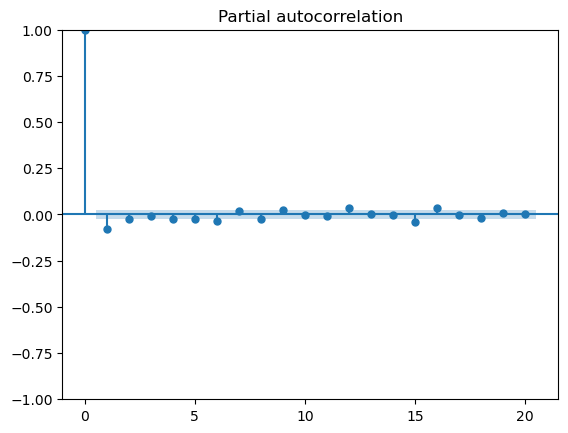

In [123]:
plot_pacf(df_return['Log return'], lags=20)
plt.title('Partial autocorrelation')
plt.show()